<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/MultiLabel_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 

In [3]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab

import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter


from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
!pip install wandb -qq
import wandb

In [4]:
#Accessing google colab and append custom functions folder
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')   
  base_path = '/content/drive/MyDrive/NLP'
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fns')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fn')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Defining the path and traversing the contents in the folder
base_folder = Path(base_path)
assignment_fldr = base_folder/ 'assignment6'
custom_fldr = base_folder/ 'user-defined-fn'

#Check contents in data folder
for entries in custom_fldr.iterdir():
  print(entries.name)

data_preparation_imdb_rev0.py
.ipynb_checkpoints
__pycache__


In [6]:
sys.path = list(set(sys.path))

In [7]:
sys.path

['',
 '/usr/lib/python3.9/lib-dynload',
 '/content',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/lib/python39.zip',
 '/usr/lib/python3/dist-packages',
 '/content/drive/MyDrive/NLP/user-defined-fn',
 '/content/drive/MyDrive/NLP/user-defined',
 '/env/python',
 '/usr/local/lib/python3.9/dist-packages',
 '/content/drive/MyDrive/NLP/user-defined-fns',
 '/usr/lib/python3.9']

In [8]:
!pip install torchmetrics -qq

In [9]:
from Trainer_v2 import Trainer
from ff_3_layer_sequential_model import MLPCustom

In [10]:
from data_preparation_imdb_rev0 import *

In [11]:
#Loading the contents from folder
df_multilable_data = assignment_fldr/ 'df_multilabel_hw_cleaned.joblib'
multiLabel_Data = joblib.load(df_multilable_data)

In [12]:
multiLabel_Data.columns #Printing all df columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [13]:
multiLabel_Data.shape

(47427, 3)

In [14]:
import ast
# assume 'df' is your pandas DataFrame
multiLabel_Data['Tag_Number'] = multiLabel_Data['Tag_Number'].apply(lambda x: [int(i) for i in ast.literal_eval(x)])

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer   #Implementing MultiLabelBinarizer for multiLabel classification

# assume 'labels' is your list of labels (i.e., 'Tag_Number' column after conversion to integers)
mlb = MultiLabelBinarizer()
one_hot_labels= mlb.fit_transform(multiLabel_Data['Tag_Number'])
for i in range(len(mlb.classes_)):
    multiLabel_Data[f"one_hot_{mlb.classes_[i]}"] = one_hot_labels[:, i]

In [16]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number', 'one_hot_0', 'one_hot_1',
       'one_hot_2', 'one_hot_3', 'one_hot_4', 'one_hot_5', 'one_hot_6',
       'one_hot_7', 'one_hot_8', 'one_hot_9'],
      dtype='object')

In [17]:
X_final = multiLabel_Data['cleaned_text'].values

In [18]:
y_final = multiLabel_Data.loc[:, 'one_hot_0':'one_hot_9'].values    #Checking one-hot encoding values
unique_labels = np.unique(y_final)
print(unique_labels)

[0 1]


In [19]:
print(type(y_final), y_final.shape)

<class 'numpy.ndarray'> (47427, 10)


#Create Train/Test/Valid Split

In [20]:
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4)   #Splitting the data

In [21]:
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5)

In [22]:
print("Train set shape: ", X_train.shape, "Split %: ", len(X_train)/len(X_final))
print("Validation set shape: ", X_valid.shape,"Split %: ", len(X_valid)/len(X_final))
print("Test set shape: ", X_test.shape, "Split %: ", len(X_test)/len(X_final))

Train set shape:  (28456,) Split %:  0.59999578299281
Validation set shape:  (9485,) Split %:  0.19999156598562
Test set shape:  (9486,) Split %:  0.20001265102156998


In [23]:
trainset = CustomDataset(X_train,y_train)   #Creating train, valid & test set using custom class
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

In [24]:
print(np.unique(y_train), np.unique(y_valid), np.unique(y_test))

[0 1] [0 1] [0 1]


#Create vocab

In [25]:
multilabel_vocab = get_vocab(trainset, min_freq=2)   #Creating vocab

In [26]:
len(multilabel_vocab)

92242

In [27]:
valid_multilabel_vocab = get_vocab(validset, min_freq=2)

#Meta Data

In [28]:
from types import SimpleNamespace    #Defining parameters 

hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu,
    
    # training 
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE = 10,
    PATIENCE=5,
    MOMENTUM=0,  
)

#Trainer Configuration

In [29]:
def collate_batch_multilabel(batch, vocab):   #Defined collate batch function to support multilabel classification
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])
    return (texts, offsets), labels

In [30]:
from functools import partial   #Defined all required class instances & Other variables
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch_multilabel, vocab=multilabel_vocab)

# Data Loader
train_loader, valid_loader = get_loaders(trainset, validset, batch_size_= hyperparameters.BATCH_SIZE, 
                                         collate_fn=collate_fn)

# cross entropy loss function
loss_function = torch.nn.BCEWithLogitsLoss()
# model
model_imdb = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_DIM1,
                       hyperparameters.HIDDEN_DIM2,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,
                             weight_decay=hyperparameters.WEIGHT_DECAY,
                             )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
for (texts, offsets), labels in train_loader:   #Traversing the train_loader
  print(labels, texts, offsets)
  break

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.]]) tensor([  540, 17584,    16,  ...,   209,  7293,  7294]) tensor([    0,   242,   381,   444,   503,   652,   817,   958,  1005,  1032,
         1118,  1203,  1549,  1571,  1636,  1680,  1700,  1797,  1850,  1969,
         2048,  2124,  2379,  2486,  2605,  2649,  2681,  2693,  2764,  2823,
         2857,  2896,  3076,  3321,  3422,  3462,  3564,  3607,  3650,  3755,
         3802,  3862,  4120,  4140,  4170,  4248,  4299,  4352,  4423,  4505,
         4596,  4631,  4697,  4752,  4774,  4810,  4935,  4990,  5019,  5060,
         5122,  5197,  5390,  5420,  5470,  5528,  5597,  5890,  5985,  6007,
         6044,  6160,  6204,  6277,  6363,  6454,  6480,  6681,  6684,  6757,
         6806,  6883,  6900,  7040,  7063,  7153,  7187,  7234,  

<ipython-input-29-eca38cbe030c>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels, dtype=torch.float32)


#Training Model

In [32]:
trainer = Trainer(model=model_imdb, optimizer=optimizer,         
                  criterion=loss_function, device=device)       #creating class instance

In [33]:
from torchmetrics.classification import MultilabelHammingDistance     #Defining other class instances and variables
run_folder = assignment_fldr/'rev2'
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

# set metric -- OPTIONAL
train_metric = MultilabelHammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
valid_metric = MultilabelHammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=1, save_last_epoch=False)

# set early stopping -- OPTIONAL
trainer.set_early_stopping(patience = hyperparameters.PATIENCE)

# set gradient Clipping  -- OPTIONAL
trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

In [34]:
trainer.sanity_check(num_classes=2)   #Doing sanity check

Actual loss: 0.6742189526557922
Expected Theoretical loss: 0.6931471805599453


In [35]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)    #Training the model

Epoch 1/5 - Train Loss: 0.5746, Train Metric: 0.2704, Train Time: 0:00:03.228184
Epoch 1/5 - Val Loss: 0.2339, Val Metric: 0.0741, Val Time: 0:00:00.836388

Epoch 2/5 - Train Loss: 0.2361, Train Metric: 0.0848, Train Time: 0:00:03.312485
Epoch 2/5 - Val Loss: 0.1622, Val Metric: 0.0590, Val Time: 0:00:00.794074

Epoch 3/5 - Train Loss: 0.1777, Train Metric: 0.0641, Train Time: 0:00:03.294919
Epoch 3/5 - Val Loss: 0.1428, Val Metric: 0.0522, Val Time: 0:00:00.820113

Epoch 4/5 - Train Loss: 0.1518, Train Metric: 0.0542, Train Time: 0:00:03.211055
Epoch 4/5 - Val Loss: 0.1307, Val Metric: 0.0482, Val Time: 0:00:00.790137

Epoch 5/5 - Train Loss: 0.1341, Train Metric: 0.0479, Train Time: 0:00:03.231810
Epoch 5/5 - Val Loss: 0.1221, Val Metric: 0.0449, Val Time: 0:00:00.796349



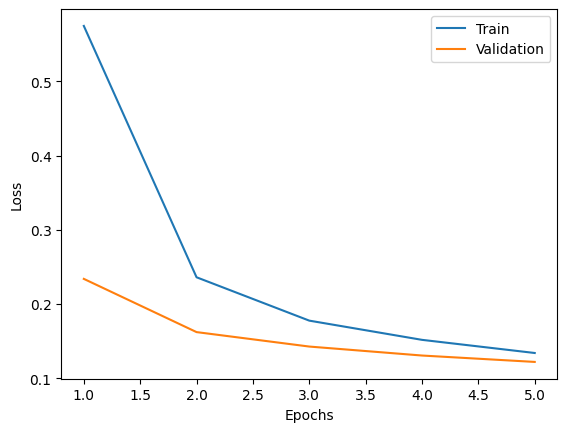

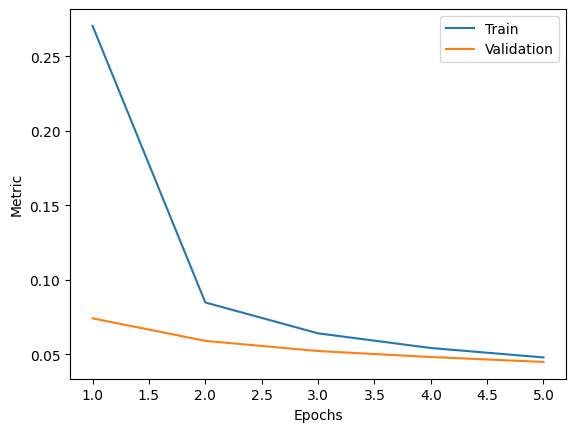

In [36]:
trainer.plot_history()   #plotting the train & validation loss 

In [37]:
trainer.best_epoch   #Displaying best epoch number 

5

In [38]:
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'     #Saving the epoch
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/MyDrive/NLP/assignment6/rev2/checkpoint_2023-04-10_03-58-10_best.pt'.


In [39]:
trainer.train(num_epochs=10, multilabel=True)  #Rerunning the model again 10 times

Epoch 1/10 - Train Loss: 0.1186, Train Metric: 0.0423, Train Time: 0:00:03.207281
Epoch 1/10 - Val Loss: 0.1167, Val Metric: 0.0429, Val Time: 0:00:00.796738

Epoch 2/10 - Train Loss: 0.1078, Train Metric: 0.0387, Train Time: 0:00:03.169728
Epoch 2/10 - Val Loss: 0.1119, Val Metric: 0.0408, Val Time: 0:00:00.822383

Epoch 3/10 - Train Loss: 0.0974, Train Metric: 0.0350, Train Time: 0:00:03.209095
Epoch 3/10 - Val Loss: 0.1076, Val Metric: 0.0393, Val Time: 0:00:00.795086

Epoch 4/10 - Train Loss: 0.0896, Train Metric: 0.0321, Train Time: 0:00:03.191739
Epoch 4/10 - Val Loss: 0.1061, Val Metric: 0.0380, Val Time: 0:00:00.799408

Epoch 5/10 - Train Loss: 0.0808, Train Metric: 0.0291, Train Time: 0:00:03.283298
Epoch 5/10 - Val Loss: 0.1034, Val Metric: 0.0362, Val Time: 0:00:00.794907

EarlyStopping counter: 1 out of 5
Epoch 6/10 - Train Loss: 0.0744, Train Metric: 0.0267, Train Time: 0:00:03.191665
Epoch 6/10 - Val Loss: 0.1037, Val Metric: 0.0357, Val Time: 0:00:00.801756

Epoch 7/10 -

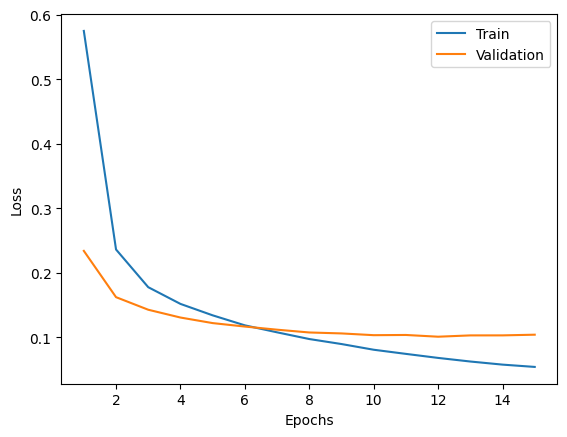

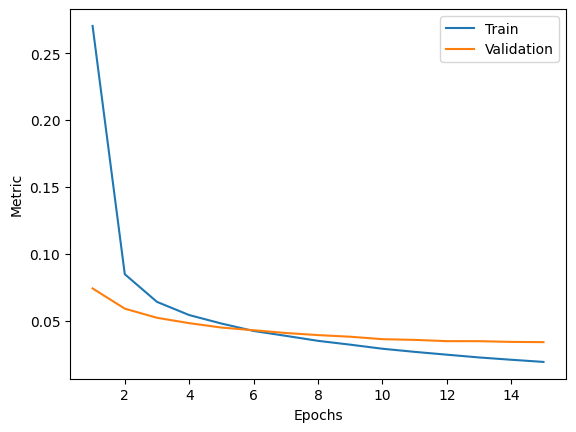

In [40]:
trainer.plot_history()  #Replotting the train & valid loss

In [41]:
trainer.best_epoch #displaying the best epoch

11

#Get Accuracy, Predictions

In [42]:
test_multilabel_vocab = get_vocab(testset, min_freq=2)   #Create test vocab

In [43]:
collate_fn = partial(collate_batch_multilabel, vocab=test_multilabel_vocab)    #Creating test loader
test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [44]:
for (texts, offsets), labels in test_loader:   #Traversing the test loader
  print(labels, texts, offsets)
  break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.]]) tensor([  1,   2,   0,  ...,   6, 236,   8]) tensor([    0,    91,   157,   380,   415,   447,   597,   621,   637,   664,
          682,   690,   809,   838,   891,   958,  1062,  1081,  1285,  1321,
         1364,  1454,  1499,  1532,  1603,  1701,  1891,  1947,  2070,  2104,
         2125,  2221,  2263,  2317,  2384,  2413,  2426,  2481,  2559,  2739,
         2830,  2891,  3112,  3173,  3321,  3421,  3484,  3910,  3992,  4140,
         4161,  4217,  4274,  4297,  4377,  4622,  4675,  4710,  4767,  4876,
         4945,  5120,  5336,  5383,  5637,  5829,  5895,  6108,  6141,  6185,
         6270,  6323,  6373,  6425,  6455,  6495,  6532,  6567,  6602,  6673,
         6721,  6890,  6945,  7026,  7058,  7100,  7126,  7162,  7190,  7277,

In [45]:
#Predicting train, valid & test dataset
predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True, multilabel=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True, multilabel=True)
predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True, multilabel=True)

In [46]:
print(target_train.shape, predictions_train.shape)   #Displaying the train, valid & test target & predicted shape
print(target_valid.shape, predictions_valid.shape)
print(target_test.shape, predictions_test.shape)

torch.Size([28456, 10]) torch.Size([28456, 10])
torch.Size([9485, 10]) torch.Size([9485, 10])
torch.Size([9486, 10]) torch.Size([9486, 10])


In [47]:
import torchmetrics

In [48]:
#Calculating the multilable F1 score & hamming distance
from torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
num_classes = target_train.shape[-1]
f1_score_train = multilabel_f1_score(target_train, predictions_train, average='micro',num_labels=num_classes)
hamming_distance_train = multilabel_hamming_distance(target_train,predictions_train, num_labels=num_classes)
print("Train F1 Score: ",f1_score_train, " Train hamming distance: ", hamming_distance_train)
num_classes = target_valid.shape[-1]
f1_score_valid = multilabel_f1_score(target_valid,predictions_valid, average='micro',num_labels=num_classes)
hamming_distance_valid = multilabel_hamming_distance(target_valid,predictions_valid, num_labels=num_classes)
print("Train F1 Score: ",f1_score_valid, " Train hamming distance: ", hamming_distance_valid)
num_classes = target_test.shape[-1]
f1_score_test = multilabel_f1_score(target_test, predictions_test, average='micro', num_labels=num_classes)
hamming_distance_test = multilabel_hamming_distance(target_test,predictions_test,num_labels=num_classes)
print("Test F1 Score: ",f1_score_test, " Test hamming distance: ", hamming_distance_test)

Train F1 Score:  tensor(0.9766)  Train hamming distance:  tensor(0.0096)
Train F1 Score:  tensor(0.9171)  Train hamming distance:  tensor(0.0340)
Test F1 Score:  tensor(0.2324)  Test hamming distance:  tensor(0.3051)
